In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] = (14,8)
sns.set_style('darkgrid')

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("./Data/gold.csv")
df.Date = pd.to_datetime(df.Date,format='%Y-%m-%d') #%Y-%m-%d
df.set_index('Date',inplace=True)

# b: business day, monday to friday
# ffill: forward fill nếu bị thiếu lấp bằng giá trị gần nhất trước đó
df = df.asfreq('b','ffill')
del df['Currency']
df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2000-01-04,281.0,281.0,281.0,282.7,4
2000-01-05,283.2,283.2,283.2,281.1,16
2000-01-06,281.4,281.4,281.4,281.4,0
2000-01-07,281.9,281.9,281.9,281.9,0
2000-01-10,281.7,281.7,281.7,281.7,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5837 entries, 2000-01-04 to 2022-05-18
Freq: B
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5837 non-null   float64
 1   High    5837 non-null   float64
 2   Low     5837 non-null   float64
 3   Close   5837 non-null   float64
 4   Volume  5837 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 273.6 KB


In [4]:
# thống kê mô tả 1 số cột
# count: số lượng không thiếu
# mean: giá trị trung bình
# std: độ lệch chuẩn
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,5837.0,1027.670451,515.497384,255.0,444.0,1180.9,1359.3,2062.4
High,5837.0,1033.613382,519.312552,255.0,444.2,1187.5,1367.2,2078.8
Low,5837.0,1021.301364,511.187197,255.0,443.0,1172.7,1352.0,2033.6
Close,5837.0,1030.556265,517.023386,255.1,444.2,1183.0,1380.0,2054.6
Volume,5837.0,34950.354977,92352.463427,0.0,20.0,197.0,1351.0,816531.0


In [5]:
# lọc dữ liệu từ năm 2000
data = df[df.index > '2000']

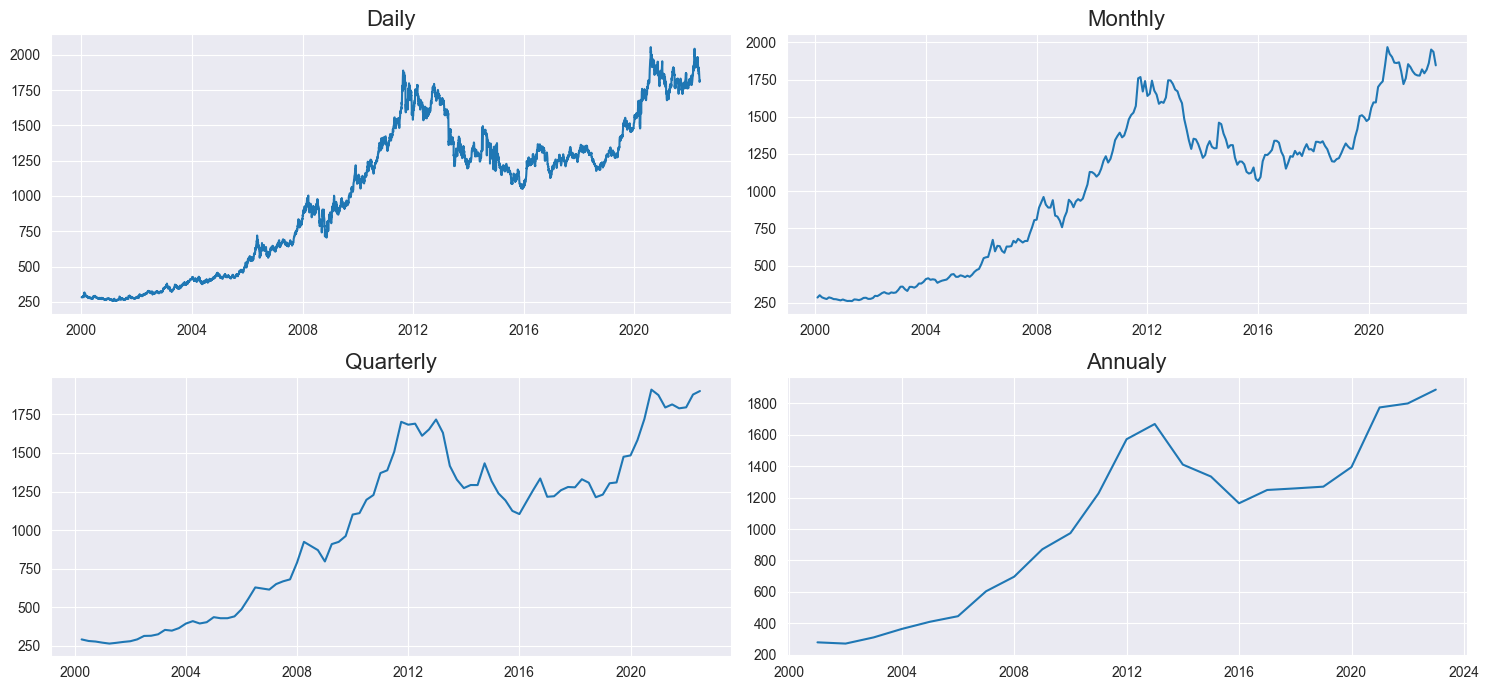

In [6]:
fig,axes = plt.subplots(2,2,figsize=[15,7])

# lấy dữ liệu đóng cửa 
axes[0,0].plot(data.Close)
axes[0,0].set_title("Daily",size=16)

# resample('M').mean(): Lấy trung bình giá đóng cửa theo từng tháng (M - monthly)
axes[0,1].plot(data.Close.resample('M').mean())
axes[0,1].set_title("Monthly",size=16)

axes[1,0].plot(data.Close.resample('Q').mean())
axes[1,0].set_title('Quarterly',size=16)

axes[1,1].plot(data.Close.resample('A').mean())
axes[1,1].set_title('Annualy',size=16)

# căn chỉnh biểu đồ
plt.tight_layout()
plt.show()


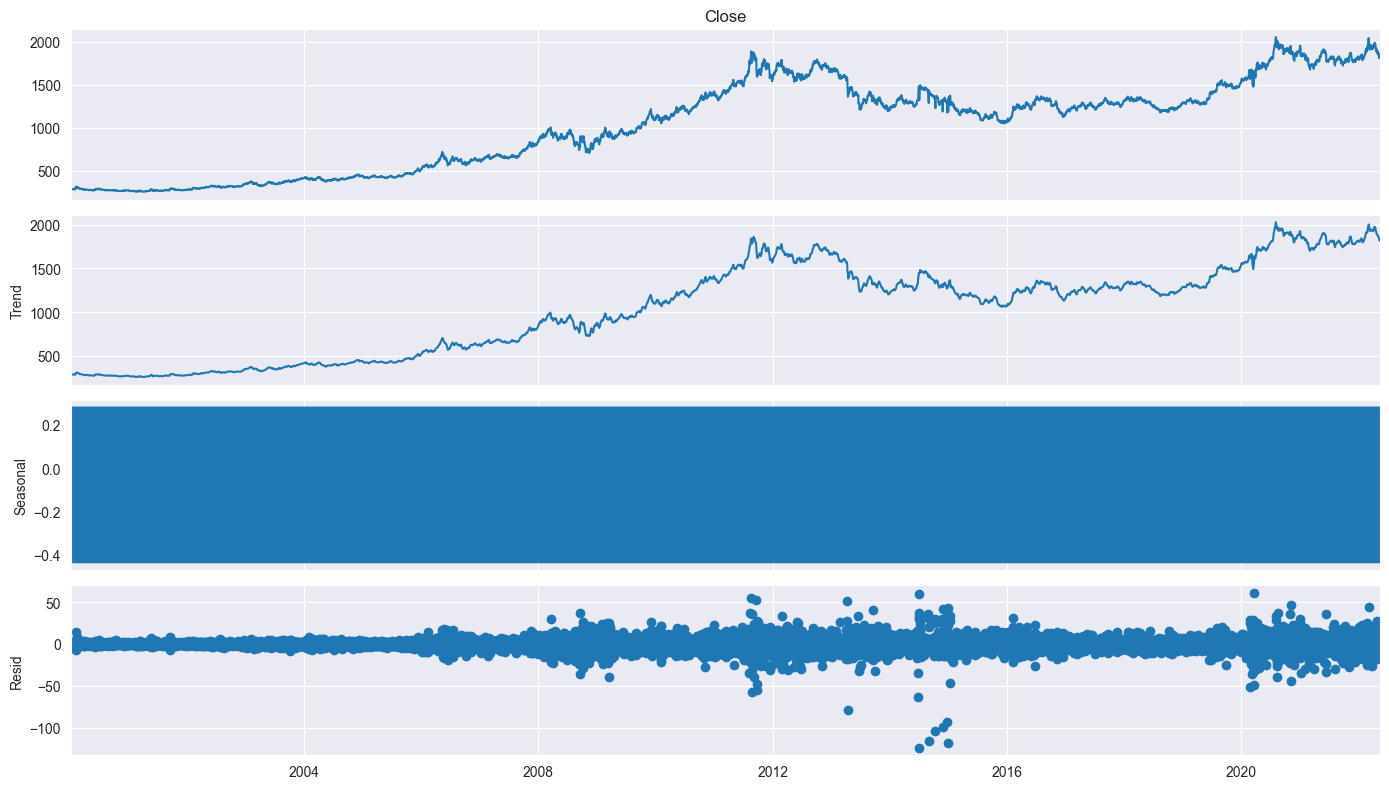

In [7]:
# phân rã chuỗi thời gian
decompose_result = seasonal_decompose(data['Close'])

# trend xu hướng dài hạn
trend = decompose_result.trend

# Seasonal: Thành phần chu kỳ hoặc mùa vụ lặp lại theo thời gian cố định.
seasonal = decompose_result.seasonal

# Residual: Phần dư (nhiễu) còn lại sau khi loại bỏ xu hướng và mùa vụ.
residual = decompose_result.resid

# hiển thị thanhf phần đã phân rã
decompose_result.plot();

trend: This variable stores the trend component of the decomposition. It represents the long-term, upward or downward movement of the price series.
seasonal: This variable stores the seasonal component of the decomposition. It represents the periodic fluctuations in the price series that occur at regular intervals (e.g., monthly, quarterly, yearly).
residual: This variable stores the residual component of the decomposition. It represents the random fluctuations in the price series that cannot be explained by the trend or seasonal components.

In [8]:
def stationarity_check(series):
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(series, autolag='AIC') 
    
    # Test Statistic: Giá trị thống kê kiểm định.
    # p-value: Nếu p-value nhỏ (< 0.05), chuỗi được coi là dừng.
    #Stationarity means that the statistical properties of the series (mean, variance) do not change over time
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',
                                             '#Lags Used','Number of Observations Used'])
    
    # Critical Value: Giá trị tới hạn ở các mức ý nghĩa (1%, 5%, 10%).
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)

In [9]:
def plot_rolling_stats(series,window):
    
    rol_mean = series.rolling(window).mean()
    rol_std  = series.rolling(window).std()
    
    # Rolling mean: Giá trị trung bình trượt.
    # Rolling standard deviation: Độ lệch chuẩn trượt.

    fig = plt.figure(figsize=(10,5))
    orig = plt.plot(series,color='blue',label='Original')
    mean = plt.plot(rol_mean,color='red',label='Rolling mean')
    std  = plt.plot(rol_std,color='black',label='Rolling std')
    
    plt.title('Rolling Mean/Standard Deviation',size=20)
    plt.legend(loc='best')
    plt.show(block=False)

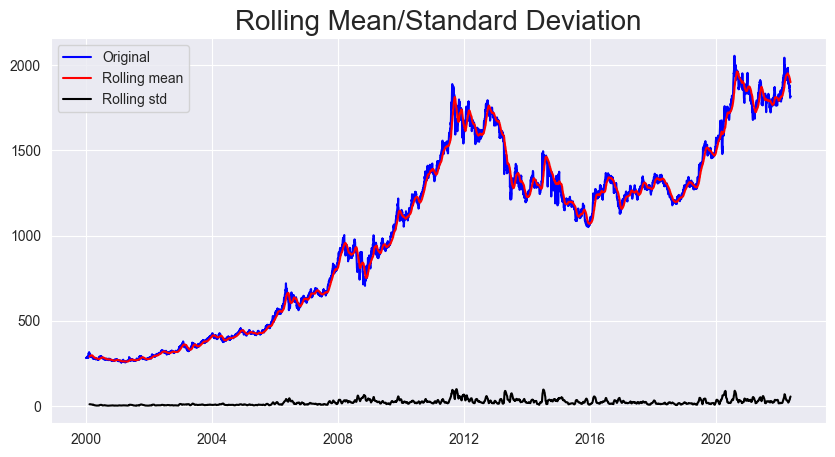

Results of Dickey Fuller Test:
Test Statistic                   -0.662646
p-value                           0.856189
#Lags Used                       33.000000
Number of Observations Used    5803.000000
Critical Value (1%)              -3.431477
Critical Value (5%)              -2.862038
Critical Value (10%)             -2.567035
dtype: float64


In [10]:
# Biểu đồ: Giúp kiểm tra trực quan xem chuỗi có ổn định quanh giá trị trung bình hay không.
# Nếu đường trung bình và độ lệch chuẩn ổn định, chuỗi có xu hướng dừng.
plot_rolling_stats(data.Close,30)

#Nếu p-value < 0.05 và Test Statistic nhỏ hơn Critical Value, chuỗi là dừng.
stationarity_check(data.Close)

# Mục đích: Kiểm tra chuỗi có dừng không. 
# Nếu chuỗi không dừng, cần thực hiện biến đổi (ví dụ: sai phân - differencing) trước khi áp dụng mô hình ARIMA.
# ==> p < 0.05, Test Statistic > Critical Value ==> Chuỗi không dừng ==> Cần thực hiện sai phân

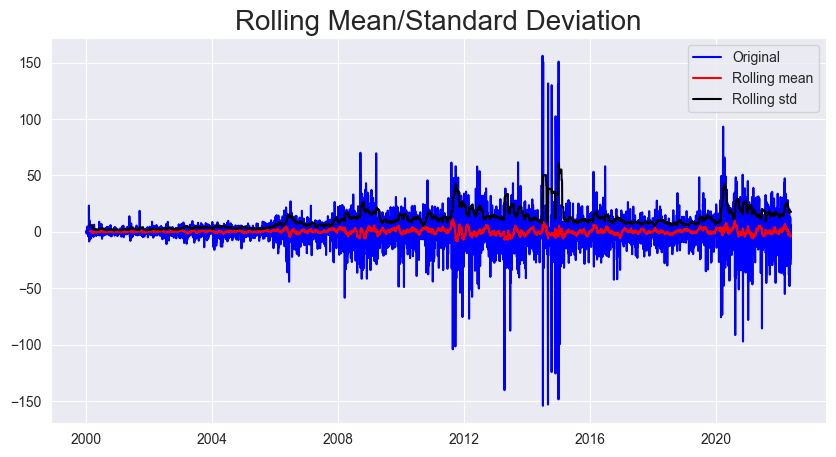

Results of Dickey Fuller Test:
Test Statistic                -1.426812e+01
p-value                        1.389238e-26
#Lags Used                     3.200000e+01
Number of Observations Used    5.803000e+03
Critical Value (1%)           -3.431477e+00
Critical Value (5%)           -2.862038e+00
Critical Value (10%)          -2.567035e+00
dtype: float64


In [11]:
# Differencing: Là phép trừ giữa giá trị hiện tại và giá trị trước đó.
plot_rolling_stats(data.Close.diff()[1:],30)
stationarity_check(data.Close.diff()[1:])

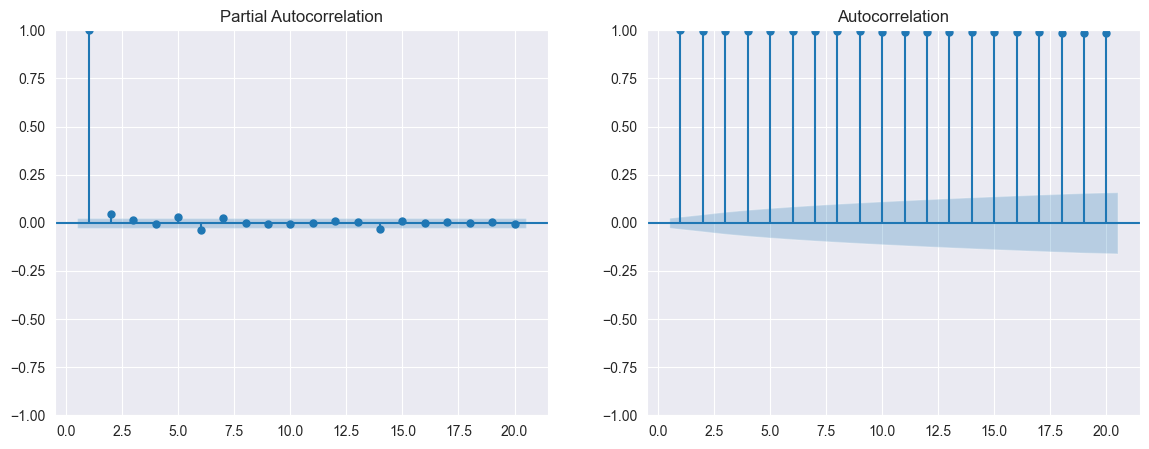

In [12]:
fig = plt.figure(figsize=(14,5))
ax_1 = fig.add_subplot(121)
plot_pacf(data.Close,lags=20,zero=False,ax=ax_1);

ax_2 = fig.add_subplot(122)
plot_acf(data.Close,lags=20,zero=False,ax=ax_2);

In [13]:
class Data:
    def __init__(self,dataset,window,forecast_steps=1):
        self.dataset = dataset
        self.window = window
        self.steps = forecast_steps
        self.index = 0
    
    def get_train(self):
        training_data = self.dataset[self.index:self.index+self.window]
        return training_data.values
    
    def get_test(self):
        test_index = self.index+self.window
        test_data = self.dataset[test_index:test_index+self.steps]
        return test_data.values
    
    def get_data(self):
        train = self.get_train() 
        test  = self.get_test()
        self.index+= self.steps
        return train, test

In [14]:
def test_arima_configs(dataset, arima_orders, window, steps):
    results = []
    predictions_store = {}
    date_index = pd.date_range(start=train_data.index[window], end=train_data.index[-1], freq='b')
    iterations = int((len(train_data) - window) / steps)
    
    for order in arima_orders:
        dataset_obj = Data(dataset, window, steps)
        predictions = []
        
        for _ in range(iterations):
            try:
                train, test = dataset_obj.get_data()
                model = ARIMA(train, order=order).fit()
                predictions.append(model.forecast(steps=steps)[0])
            except IndexError:
                break

        # Calculate error metrics
        rmse = np.sqrt(mean_squared_error(dataset[window:], predictions))
        mae = mean_absolute_error(dataset[window:], predictions)
        mape = mean_absolute_percentage_error(dataset[window:], predictions)
        # Store results
        results.append({'Order': order, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape})
        
        # Store predictions
        predictions_store[f'ARIMA{order}'] = predictions

    # Return results and predictions
    return pd.DataFrame(results), pd.DataFrame(predictions_store, index=date_index)

       Order       RMSE       MAE      MAPE
0  (0, 1, 1)  14.959851  8.344782  0.008985
1  (1, 1, 1)  15.892883  9.157127  0.009874
2  (1, 1, 0)  15.161323  8.491514  0.009165


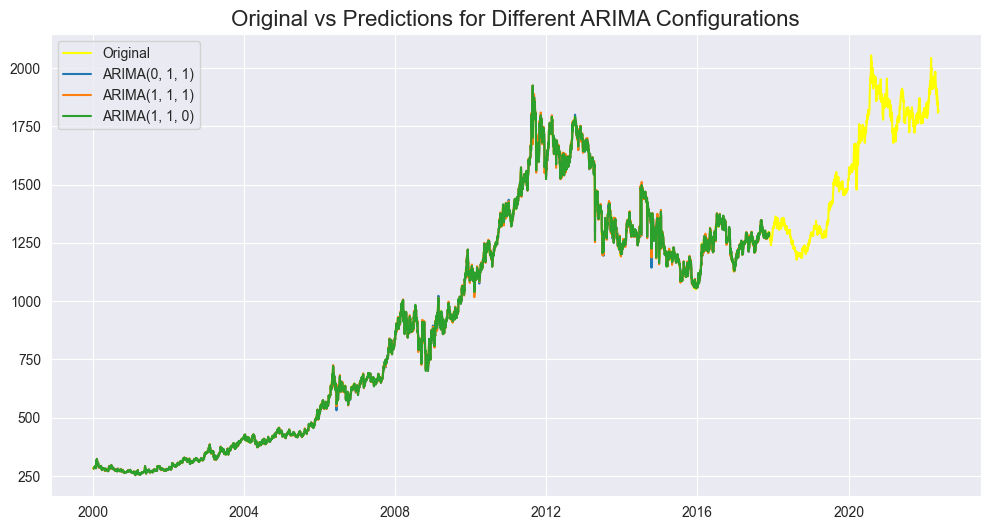

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error, mean_squared_error
steps = 1
window = 5
train_size = 0.8

train_data, test_data = train_test_split(data.Close, train_size=train_size, shuffle=False)
 
arima_orders = [(0, 1, 1), (1, 1, 1), (1, 1, 0)]
results_df, predictions_df = test_arima_configs(train_data, arima_orders, window, steps)

print(results_df)  # View metrics comparison

# Plot original vs. predictions for all configurations
plt.figure(figsize=(12, 6))
plt.plot(data.Close, label='Original', color='yellow')
for column in predictions_df.columns:
    plt.plot(predictions_df[column], label=column)
plt.legend()
plt.title('Original vs Predictions for Different ARIMA Configurations', size=16)
plt.show()
